In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import cv2


In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
P = 400                      # Crop Size
#img_size = 400
N, H, K = P**2, 50, 2      # No. of input features (input layer size), hidden layer size, No. of classes (output layer size)
num_epochs, batch_size = 2, 20
learning_rate = 0.001


train_size is 158 and test size is 40
The dimensions of one batch are torch.Size([20, 1, 400, 400]) with the size of the labels being torch.Size([20])


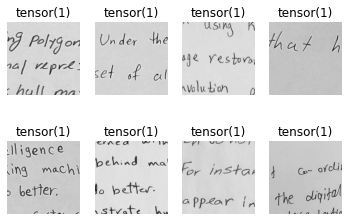

In [15]:
def prepare_dataset():

    transformations = transforms.Compose([transforms.ToTensor(), 
    #transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(P)                           # We'll train on a random crop of the image.
    ])                          
   
    handwritten_dataset = torchvision.datasets.ImageFolder(root='./CMP23-Dataset', transform=transformations)   
    # This will read the data, apply transformations and give labs of 0 and 1

    # Split the data randomly into a training and testing set:
    train_size = int(0.8 * len(handwritten_dataset))
    test_size = len(handwritten_dataset) - train_size
    train_dataset, test_dataset = utils.random_split(handwritten_dataset, [train_size, test_size])
    print(f"train_size is {train_size} and test size is {test_size}")

    # Data loader: now they are converted to batches of [batch_size, 1, P, P]
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Loop on 6 images in the first batch of the training and print them (after transformations and all)
    examples = iter(train_loader)
    example_data, example_targets = examples.next()     #hands on the first batch

    print(f"The dimensions of one batch are {example_data.shape} with the size of the labels being {example_targets.shape}")

    for i in range(8):
         ax = plt.subplot(2,4,i+1)
         ax.title.set_text(example_targets[i])
         plt.axis('off')
         plt.imshow(example_data[i].squeeze(), cmap='gray')  #first 6 images in the first batch. Squeeze so 1xPxP -> PxP
    plt.show()
    return train_loader, test_loader

train_loader, test_loader = prepare_dataset()
    

In [16]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, N, H, K):                    # Give the model the no. of neurons in the input, hidden and output layers
        super(NeuralNet, self).__init__()

        self.netLayers= nn.Sequential(
        nn.Linear(N, H), nn.ReLU(),                 # First hidden Layer             
        nn.Linear(H, K)                             # Output Layer
        )

        self.N = N
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()      # Loss function
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)  # To minimize loss
       
    def forward(self, x):
        logits = self.netLayers(x)
        return logits

    def train(self, num_epochs, train_loader):
        for epoch in range(num_epochs):
            for  (images, labels) in tqdm(train_loader):  #each batch is a tuple of images and their corresponding labels.
                
                images = nn.Flatten()(images).to(device)        # from [batch_size, 1, P, P] to [batch_size, P**2]
                labels = labels.to(device)                      # [batch_size] : Dataset labels of current batch
                
                # Forward pass
                logits = self(images)                          # Propagate the batch: gives output [batch_size, K] 
                loss = self.criterion(logits, labels)          # Calculate the loss (uses Softmak on the outputs along the way)
                
                # Backward Pass
                self.optimizer.zero_grad()                     # Clear the gradients for all network parameters (e.g. due to a previous batch)
                loss.backward()                                # Accumulate all the gradients due to the current batch
                self.optimizer.step()                          # Update the network's weights and biases
                
        
    
    def test(self, test_loader):
        with torch.no_grad():
            n_correct = 0
            n_correct_rand = 0
            for test_images, test_labels in test_loader:
                test_images = test_images.reshape(-1, P**2).to(device)     # Flattening the image first
                test_labels = test_labels.to(device)
                logits = self(test_images)                                 # Propagate the test batch
                predicted = logits.argmax(1)                    #the highest logit is also the highest softmax probability. This has shape (batch_size,)
                n_correct += (predicted == test_labels).sum().item()

                random_guess = torch.from_numpy(np.random.randint(0,2,len(predicted)))
                n_correct_rand += (random_guess == test_labels).sum().item()

            acc = 100.0 * n_correct / (len(test_loader) * batch_size)
            acc_rand = 100.0 * n_correct_rand / (len(test_loader) * batch_size)
            print(f'Model Accuracy is at {acc} and Random Guessing Accuracy is at {acc_rand} %')
    


In [17]:
def predict_gender(handwriting, saved=False):
    model = NeuralNet(N, H, K).to(device)      #so it's done on the GPU if available.

    # Load or Train the model
    if saved:
        model.load_state_dict(torch.load('./Intelligence/GenderIntelligence.pth'))
    else:
        train_loader, test_loader = prepare_dataset()                            # Prepare dataset
        model.train(num_epochs, train_loader)                                    # Train the model
        model.test(test_loader)                                                  # Test the model
        torch.save(model.state_dict(), './Intelligence/GenderIntelligence.pth')

    if(handwriting):
       pass
    return ''


train_size is 158 and test size is 40
The dimensions of one batch are torch.Size([20, 1, 400, 400]) with the size of the labels being torch.Size([20])


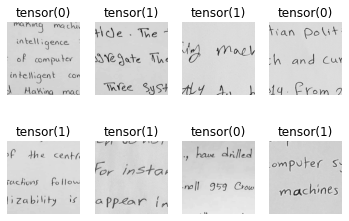

100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Model Accuracy is at 37.5 and Random Guessing Accuracy is at 35.0 %


In [18]:
predict_gender('');